In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import seaborn as sns

In [23]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [64]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [65]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [66]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [67]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [68]:
bc_map[r, c] = rand_alleles[r, c]

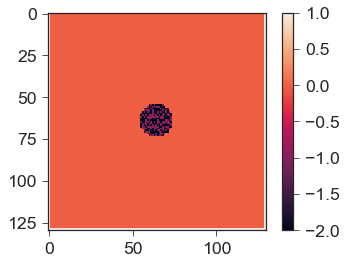

In [69]:
plt.imshow(bc_map)
plt.colorbar()

In [70]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [71]:
k_list = [.01, .01]
m_reproduce_list = [1, 1]

In [72]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=1, k_list=k_list, m_reproduce_list=m_reproduce_list)

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 9.0.282
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1594 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024L, 1024L, 64L]
---------------------------
This context is associated with  1 devices
global_size_bc: (160, 144)


In [73]:
dla_colony.kernel_args

{'D': 1.0,
 'bc_map': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d22090>,
 'bc_map_streamed': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d220d0>,
 'buf_nx': 34,
 'buf_ny': 18,
 'buf_nz': None,
 'c_mag': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d24f90>,
 'c_vec': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d24fd0>,
 'cs': 0.5773502691896258,
 'f': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d222d0>,
 'f_streamed': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d22350>,
 'feq': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d22250>,
 'halo': 1,
 'k_list': <pyopencl.cffi_cl.Buffer at 0x7fcbb85fd890>,
 'm_reproduce_list': <pyopencl.cffi_cl.Buffer at 0x7fcbb85fd910>,
 'nx_bc': 130,
 'ny_bc': 130,
 'nz_bc': None,
 'reflect_index': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d24f50>,
 'rho': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d221d0>,
 'slip_index': <pyopencl.cffi_cl.Buffer at 0x7fcbc2d22050>}